In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
class FoodDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.images = []

        for file_name in os.listdir(folder_path):
            if file_name.endswith(".jpg"):
                label = 1 if file_name.startswith("1") else 0  # 1_xxx.jpg => Food, 0_xxx.jpg => Non-Food
                self.images.append((file_name, label))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name, label = self.images[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
data_dir = "Food-5K"

train_dataset = FoodDataset(folder_path=f"{data_dir}/training", transform=train_transform)
val_dataset = FoodDataset(folder_path=f"{data_dir}/validation", transform=val_test_transform)
test_dataset = FoodDataset(folder_path=f"{data_dir}/evaluation", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 2990, Validation: 1000, Test: 1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


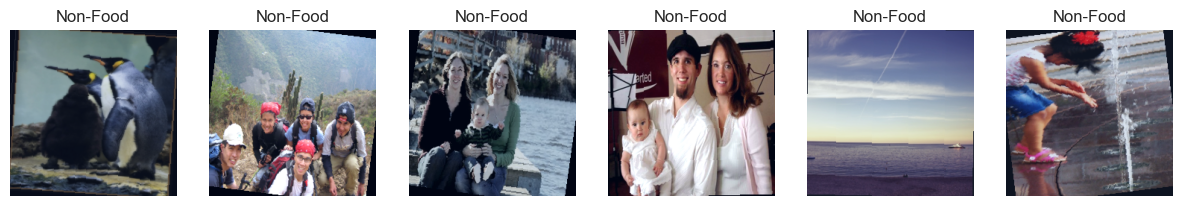

In [5]:
def show_sample_images(dataset, num_images=6):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert from tensor to numpy
        img = img * 0.229 + 0.485  # Unnormalize (approximate)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title("Food" if label == 1 else "Non-Food")
    plt.show()

show_sample_images(train_dataset)

In [6]:
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Modify output layer for 2 classes
model = model.to(device)

# Freeze all layers except the last 6
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

C:\Users\Tayyab Anees\OneDrive\Desktop\OR PROJECT\foodClassifier\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tayyab Anees\OneDrive\Desktop\OR PROJECT\foodClassifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def evaluate_model(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

In [8]:
def train_model(model, train_loader, val_loader, epochs=10):
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        val_acc = evaluate_model(model, val_loader)

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "googlenet_food_best.pth")

    print("Training Complete. Best Validation Accuracy: {:.2f}%".format(best_val_acc))

In [9]:
train_model(model, train_loader, val_loader, epochs=10)
# Load best model & test
model.load_state_dict(torch.load("googlenet_food_best.pth"))
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/10: 100%|██████████| 94/94 [02:51<00:00,  1.83s/it]


Epoch [1/10] - Loss: 0.2953, Train Acc: 89.83%, Val Acc: 98.10%


Epoch 2/10: 100%|██████████| 94/94 [02:50<00:00,  1.81s/it]


Epoch [2/10] - Loss: 0.1576, Train Acc: 94.98%, Val Acc: 97.80%


Epoch 3/10: 100%|██████████| 94/94 [03:07<00:00,  1.99s/it]


Epoch [3/10] - Loss: 0.1315, Train Acc: 95.59%, Val Acc: 98.40%


Epoch 4/10: 100%|██████████| 94/94 [08:18<00:00,  5.31s/it]


Epoch [4/10] - Loss: 0.1087, Train Acc: 96.42%, Val Acc: 97.50%


Epoch 5/10: 100%|██████████| 94/94 [02:52<00:00,  1.83s/it]


Epoch [5/10] - Loss: 0.1026, Train Acc: 96.62%, Val Acc: 98.50%


Epoch 6/10: 100%|██████████| 94/94 [02:59<00:00,  1.91s/it]


Epoch [6/10] - Loss: 0.0987, Train Acc: 96.35%, Val Acc: 98.40%


Epoch 7/10: 100%|██████████| 94/94 [03:18<00:00,  2.12s/it]


Epoch [7/10] - Loss: 0.0935, Train Acc: 96.69%, Val Acc: 98.20%


Epoch 8/10: 100%|██████████| 94/94 [02:49<00:00,  1.80s/it]


Epoch [8/10] - Loss: 0.0831, Train Acc: 96.89%, Val Acc: 98.30%


Epoch 9/10: 100%|██████████| 94/94 [03:09<00:00,  2.02s/it]


Epoch [9/10] - Loss: 0.0849, Train Acc: 97.12%, Val Acc: 98.20%


Epoch 10/10: 100%|██████████| 94/94 [02:48<00:00,  1.79s/it]


Epoch [10/10] - Loss: 0.0827, Train Acc: 97.06%, Val Acc: 98.30%
Training Complete. Best Validation Accuracy: 98.50%
Test Accuracy: 97.80%


C:\Users\Tayyab Anees\OneDrive\Desktop\OR PROJECT\foodClassifier\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Tayyab Anees\OneDrive\Desktop\OR PROJECT\foodClassifier\Lib\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


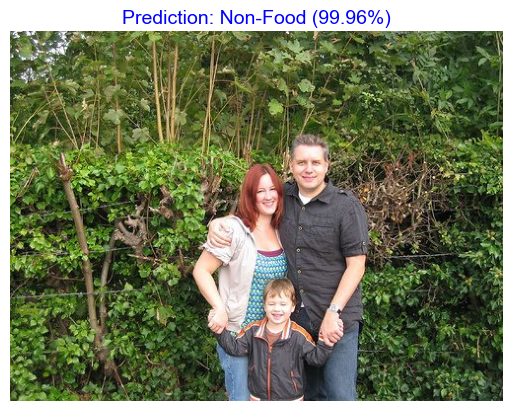

Predicted Class: Non-Food | Confidence: 99.96%


In [10]:
# Define preprocessing for the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match GoogLeNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_single_image(model_path, image_path):
    # Load GoogLeNet with auxiliary classifiers disabled
    model = models.googlenet(pretrained=False, aux_logits=False)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Modify last layer for 2 classes
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))  # Load best model
    model.eval()  # Set to evaluation mode

    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Convert logits to probabilities
        confidence, predicted_class = torch.max(probabilities, 1)

    # Map predictions to class names
    class_names = ["Non-Food", "Food"]
    predicted_label = class_names[predicted_class.item()]
    confidence_score = confidence.item() * 100  # Convert to percentage

    # Show the image with the prediction
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_label} ({confidence_score:.2f}%)", fontsize=14, color="blue")
    plt.show()

    # Print results
    print(f"Predicted Class: {predicted_label} | Confidence: {confidence_score:.2f}%")
    
    return predicted_label, confidence_score

# Example usage
model_path = "googlenet_food_best.pth"
image_path = "Food-5K/evaluation/0_54.jpg"  # Change this to your image path
result, confidence = predict_single_image(model_path, image_path)


✅ Accuracy: 97.80%


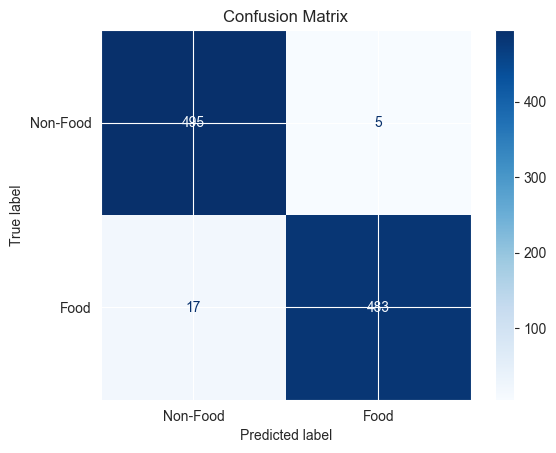


📊 Classification Report:

              precision    recall  f1-score   support

    Non-Food       0.97      0.99      0.98       500
        Food       0.99      0.97      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


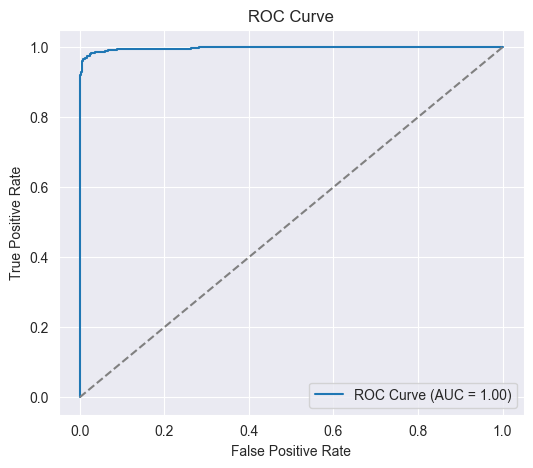

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# Collect all predictions and labels
def get_predictions_and_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1 (Food)
            _, preds = outputs.max(1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get values
preds, labels, probs = get_predictions_and_labels(model, test_loader)

# Accuracy (already done)
print(f"\n✅ Accuracy: {np.mean(preds == labels) * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(labels, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Food", "Food"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1
print("\n📊 Classification Report:\n")
print(classification_report(labels, preds, target_names=["Non-Food", "Food"]))

# ROC Curve & AUC
fpr, tpr, _ = roc_curve(labels, probs)
auc_score = roc_auc_score(labels, probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()